# Hacemos un seguidor de línea usando la cámara robot

Esta vez, haremos un seguidor de línea usando la cámara del robot. Para hacer esto, usaremos la cámara para capturar imágenes del suelo y procesarlas para detectar la línea. Luego usaremos la información obtenida para controlar el robot y hacer que siga la línea.

Para hacer esto, usaremos la librería `opencv` para procesar imágenes y `aitk.robots` para controlar el robot.

Comencemos por instalar e importar las librerías necesarias:

In [9]:
%pip install aitk numpy opencv-python-headless scikit-fuzzy matplotlib requests Pillow==9.4

In [10]:
import aitk.robots as bots
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Seguidor de línea simple

Crearemos el mundo de Robot y Robot. Necesitaremos la imagen del mapa para este ejemplo (tienes 5 diponibles de `EX2_pista_1.png` a `EX2_pista_5.png`), contiene una pista con una línea negra.

El robot tendrá una cámara que capturará imágenes del suelo y las procesará para detectar la línea. Será de tipo `GroundCamera` y la añadiremos al robot.

(677, 896, 3)


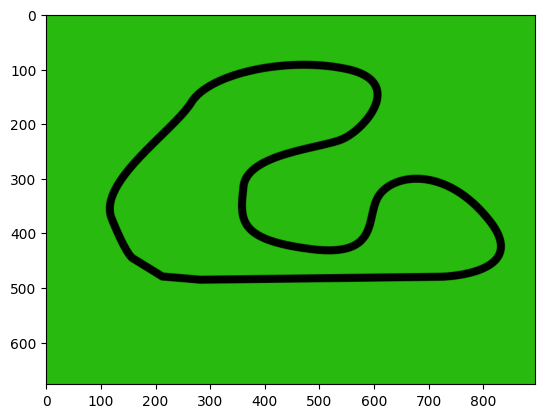

In [19]:
nom_imatge = "EX2_pista_1.png"

# Cargamos la imagen en una variable

img = cv2.imread(nom_imatge)
print(img.shape)
# Mostramos la imagen
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


In [20]:
world = bots.World(220, 180, boundary_wall_color="yellow", ground_image_filename=nom_imatge)

robot = bots.Scribbler(x=24, y=90, a=90)
robot.add_device(bots.GroundCamera(width=120, height=50))

world.add_robot(robot)

robot['ground-camera'].watch()
world.watch()

Random seed set to: 2337449


HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00x\x00\x00\x002\x08\x06\x00\x00\x00\x97\xa7\x1f\xd…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

Implementa la función `controlador_cam` que será el que tendrá que controlar el robot. Puedes basarte en el ejemplo hecho en [`1.-Introduccio_OpenCV_ES.ipynb`](https://colab.research.google.com/github/martinezpenya/MIA-IABD-2425/blob/main/UD04/notebooks/1.-Introduccio_OpenCV_ES.ipynb) para detectar la línea (ten en cuenta que la cámara aquí está debajo del robot, por lo que si usamos la parte inferior de la imagen seguramente el robot sea demasiado inestable, sería mejor usar la parte superior de la imagen) y en el ejemplo hecho en [`3.-exemples_robots_ES.ipynb`](https://colab.research.google.com/github/martinezpenya/MIA-IABD-2425/blob/main/UD04/notebooks/3.-exemples_robots_ES.ipynb) para controlar el robot.

  0%|          | 0/600 [00:00<?, ?it/s]

Simulation stopped at: 00:01:00.00; speed 0.93 x real time


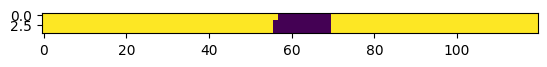

In [21]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt


def controlador_cam(robot):
    cam = robot['ground-camera']
    image = cam.get_image()

    if image is None:
        return
    image = np.array(image)
    # Convertir a escala de grises
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(img_gray)

    # Parte superior de la imagen
    img_top = img_gray[0:5,:]
    plt.imshow(img_top)

    # Blurr
    img_blurred = cv2.GaussianBlur(img_top, (3, 3), 0)
    plt.imshow(img_blurred)

    # Threshold
    ret, img_thresh = cv2.threshold(img_blurred, 110, 255, cv2.THRESH_BINARY)
    plt.imshow(img_thresh)

    # Contornos
    img_thresh_copy = img_thresh.copy()
    contours, _ = cv2.findContours(img_thresh_copy, 1, cv2.CHAIN_APPROX_NONE)

    # En determinados circuitos varios contornos del mismo tamaño
    # entran en el rango de la camara, por lo que para que el coche siga el contorno adecuado
    # se calcula cual es el contorno mas cercano al coche para que lo siga.
    if len(contours) != 0:
        center_x = img_gray.shape[1] // 2
        center_y = img_gray.shape[0] // 2

        # Inicializamos la mejor distancia y el mejor contorno
        best_contour = None
        min_distance = float('inf')

        for contour in contours:
            center = cv2.moments(contour)

            # Si se da una division por 0 se ignora
            if center['m00'] == 0:
                continue
            cx = int(center['m10'] / center['m00'])
            cy = int(center['m01'] / center['m00'])

            # Calculamos la distancia al centro de la imagen
            distance = abs(cx - center_x)

            # Seleccionamos el contorno más cercano
            if distance < min_distance:
                min_distance = distance
                best_contour = contour

        if best_contour is not None:
            center = cv2.moments(best_contour)
            cx = int(center['m10'] / center['m00'])
            cy = int(center['m01'] / center['m00'])

            if cx < center_x:
                robot.move(0.5, -0.2)
            elif cx > center_x:
                robot.move(0.5, 0.2)
            else:
                robot.move(0.5, 0)

world.reset()
world.seconds(60, [controlador_cam], real_time=True)


## Seguidor de doble línea (mantenerse en el camino)

Adapte el seguidor de la línea para que el robot pueda seguir dos líneas paralelas y permanecer en el camino. Para hacer esto, usaremos la imagen `EX2_pista__6.png` que contiene dos líneas paralelas.

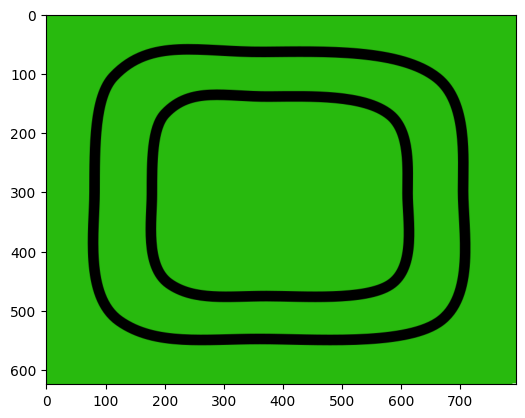

In [22]:
nom_imatge = "EX2_pista_6.png"

# Cargamos la imagen en una variable

img = cv2.imread(nom_imatge)

# Mostramos la imagen
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [23]:
world = bots.World(220, 180, boundary_wall_color="yellow", ground_image_filename=nom_imatge)

amplada_camera = 120
alcada_camera = 50
robot = bots.Scribbler(x=36, y=80, a=90)
robot.add_device(bots.GroundCamera(width=amplada_camera, height=alcada_camera))

world.add_robot(robot)

robot['ground-camera'].watch()
world.watch()

Random seed set to: 3349838


HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00x\x00\x00\x002\x08\x06\x00\x00\x00\x97\xa7\x1f\xd…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

  0%|          | 0/600 [00:00<?, ?it/s]

Simulation stopped at: 00:01:00.00; speed 0.92 x real time


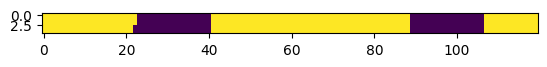

In [26]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def controlador_cam(robot):
    cam = robot['ground-camera']
    image = cam.get_image()

    if image is None:
        return
    image = np.array(image)
    # Convertir a escala de grises
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(img_gray)

    # Parte superior de la imagen
    img_top = img_gray[0:5,:]
    plt.imshow(img_top)

    # Blurr
    img_blurred = cv2.GaussianBlur(img_top, (3, 3), 0)
    plt.imshow(img_blurred)

    # Threshold
    ret, img_thresh = cv2.threshold(img_blurred, 110, 255, cv2.THRESH_BINARY)
    plt.imshow(img_thresh)

    # Contornos
    img_thresh_copy = img_thresh.copy()
    contours, _ = cv2.findContours(img_thresh_copy, 1, cv2.CHAIN_APPROX_NONE)
    if len(contours) != 0:
        # Centro de la imagen
        center_x = img_gray.shape[1] // 2
        center_y = img_gray.shape[0] // 2

        # Inicializar la mejor distancia y los mejores contornos
        best_contours = []
        min_distances = []

        for contour in contours:

            center = cv2.moments(contour)

            # Si se da una division por 0 ignorarla
            if center['m00'] == 0:
                continue
            cx = int(center['m10'] / center['m00'])
            cy = int(center['m01'] / center['m00'])

            # Calculamos la distancia al centro de la imagen
            distance = abs(cx - center_x)

            best_contours.append((contour, distance))

        # Ordenamos los contornos por la distancia al centro de la imagen
        best_contours.sort(key=lambda x: x[1])

        if len(best_contours) >= 2:
            # Cogemos los dos contornos más cercanos
            contour1, _ = best_contours[0]
            contour2, _ = best_contours[1]

            # Calculamos los centros de los dos contornos más cercanos
            center1 = cv2.moments(contour1)
            cx1 = int(center1['m10'] / center1['m00'])
            cy1 = int(center1['m01'] / center1['m00'])

            center2 = cv2.moments(contour2)
            cx2 = int(center2['m10'] / center2['m00'])
            cy2 = int(center2['m01'] / center2['m00'])

            # Calculamos el centro de a partir de los centros de los contornos
            center_x_avg = (cx1 + cx2) // 2
            center_y_avg = (cy1 + cy2) // 2

            if center_x_avg < center_x:
                robot.move(0.5, -0.2)
            elif center_x_avg > center_x:
                robot.move(0.5, 0.2)
            else:
                robot.move(0.5, 0)

world.reset()
world.seconds(60, [controlador_cam], real_time=True)

